In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


%load_ext autoreload
%autoreload 2

In [2]:
class AbelianSandpile:
    """
    An Abelian sandpile model simulation. The sandpile is initialized with a random
    number of grains at each lattice site. Then, a single grain is dropped at a random
    location. The sandpile is then allowed to evolve until it is stable. This process
    is repeated n_step times.

    A single step of the simulation consists of two stages: a random sand grain is 
    dropped onto the lattice at a random location. Then, a set of avalanches occurs
    causing sandgrains to get redistributed to their neighboring locations.
    
    Parameters:
    n (int): The size of the grid
    grid (np.ndarray): The grid of the sandpile
    history (list): A list of the sandpile grids at each timestep
    """

    def __init__(self, n=100, random_state=None):
        self.n = n
        np.random.seed(random_state) # Set the random seed
        self.grid = np.random.choice([0, 1, 2, 3], size=(n, n))
        self.history =[self.grid.copy()] # Why did we need to copy the grid?
    
    def add(self,i,j):
        self.grid[i,j]=self.grid[i,j]+1
        
        if  self.grid[i,j] < 4:
            return None

        else:
            self.grid[i,j]=self.grid[i,j]-4

            if i > 1:
                self.add(i-1,j)
            if i < self.n-1:
                self.add(i+1,j)
            if j > 1:
                self.add(i,j-1)
            if j < self.n-1:
                self.add(i,j+1)
            return None
            
        
        
    def step(self):
        """
        Perform a single step of the sandpile model. Step corresponds a single sandgrain 
        addition and the consequent toppling it causes. 

        Returns: None
        """
        x, y = np.random.choice(self.n, 2)
        self.add(x,y)


    # we use this decorator for class methods that don't require any of the attributes 
    # stored in self. Notice how we don't pass self to the method
    @staticmethod
    def check_difference(grid1, grid2):
        """Check the total number of different sites between two grids"""
        return np.sum(grid1 != grid2)

    
    def simulate(self, n_step):
        """
        Simulate the sandpile model for n_step steps.
        """
        
        for i in range(n_step):
            self.step()
            if self.check_difference(self.grid, self.history[-1]) > 0:
                self.history.append(self.grid.copy())
        return self.grid

Text(0.5, 1.0, 'Avalanche activity in most recent timesteps')

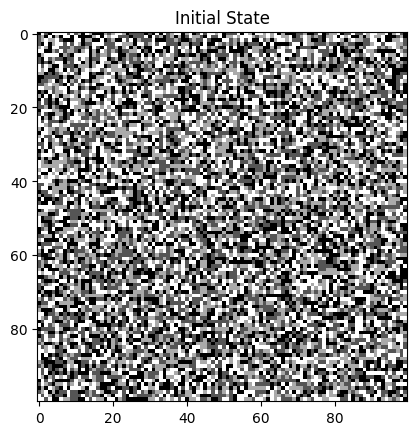

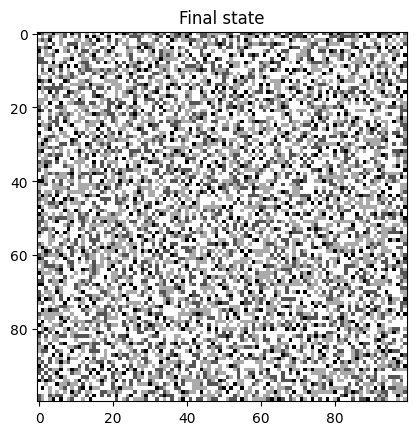

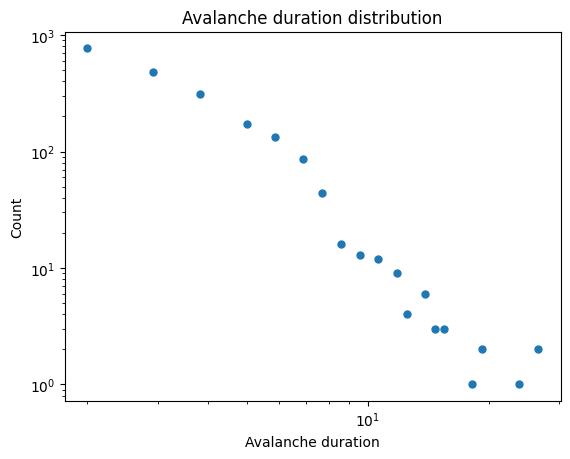

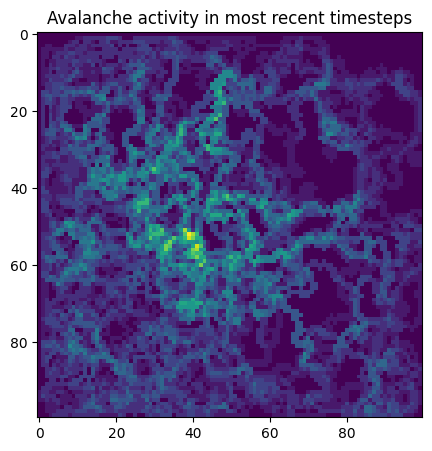

In [7]:
## Import William's solution from answer key
#from solutions.sandpile import AbelianSandpile


# Run sandpile simulation
model = AbelianSandpile(n=100, random_state=0)

plt.figure()
plt.imshow(model.grid, cmap='gray')
plt.title("Initial State")

model.simulate(10000)
plt.figure()
plt.imshow(model.grid, cmap='gray')
plt.title("Final state")




# Compute the pairwise difference between all observed snapshots. This command uses list
# comprehension, a zip generator, and argument unpacking in order to perform this task
# concisely.
all_events =  [model.check_difference(*states) for states in zip(model.history[:-1], model.history[1:])]
# remove transients before the self-organized critical state is reached
all_events = all_events[1000:]
# index each timestep by timepoint
all_events = list(enumerate(all_events))
# remove cases where an avalanche did not occur
all_avalanches = [x for x in all_events if x[1] > 1]
all_avalanche_times = [item[0] for item in all_avalanches]
all_avalanche_sizes = [item[1] for item in all_avalanches]
all_avalanche_durations = [event1 - event0 for event0, event1 in zip(all_avalanche_times[:-1], all_avalanche_times[1:])]


log_bins = np.logspace(np.log10(2), np.log10(np.max(all_avalanche_durations)), 50) # logarithmic bins for histogram
vals, bins = np.histogram(all_avalanche_durations, bins=log_bins)
plt.figure()
plt.loglog(bins[:-1], vals, '.', markersize=10)
plt.title('Avalanche duration distribution')
plt.xlabel('Avalanche duration')
plt.ylabel('Count')

## Visualize activity of the avalanches
# Make an array storing all pairwise differences between the lattice at successive
# timepoints
all_diffs = np.abs(np.diff(np.array(model.history), axis=0))
all_diffs[all_diffs > 0] = 1
all_diffs = all_diffs[np.sum(all_diffs, axis=(1, 2)) > 1] # Filter to only keep big events
most_recent_events = np.sum(all_diffs[-100:], axis=0)
plt.figure(figsize=(5, 5))
plt.imshow(most_recent_events)
plt.title("Avalanche activity in most recent timesteps")

In [ ]:
"""
Q3:
    For the worst case, the runtime would be O(N*N) becuase we will have to check all grid if they are higher than 4 at all step. 
    As for the memory, it will be O(N) since we only needs to create the grid size with N. 
    
"""

In [12]:
class PercolationSimulation:
    """
    A simulation of a 2D directed percolation problem. Given a 2D lattice, blocked sites
    are denoted by 0s, and open sites are denoted by 1s. During a simulation, water is
    poured into the top of the grid, and allowed to percolate to the bottom. If water
    fills a lattice site, it is marked with a 2 in the grid. Water only reaches a site
    if it reaches an open site directly above, or to the immediate left or right 
    of an open site.

    I've included the API for my solution below. You can use this as a starting point, 
    or you can re-factor the code to your own style. Your final solution must have a 
    method called percolate that creates a random lattice and runs a percolation 
    simulation and
    1. returns True if the system percolates
    2. stores the original lattice in self.grid
    3. stores the water filled lattice in self.grid_filled

    + For simplicity, use the first dimension of the array as the percolation direction
    + For boundary conditions, assume that any site out of bounds is a 0 (blocked)
    + You should use numpy for this problem, although it is possible to use lists 



    Attributes:
        grid (np.array): the original lattice of blocked (0) and open (1) sites
        grid_filled (np.array): the lattice after water has been poured in
        n (int): number of rows and columns in the lattice
        p (float): probability of a site being blocked in the randomly-sampled lattice
            random_state (int): random seed for the random number generator
        random_state (int): random seed for numpy's random number generator. Used to 
            ensure reproducibility across random simulations. The default value of None
            will use the current state of the random number generator without resetting
            it.
    """

    def __init__(self, n=100, p=0.5, grid=None, random_state=None):
        """
        Initialize a PercolationSimulation object.

        Args:
            n (int): number of rows and columns in the lattice
            p (float): probability of a site being blocked in the randomly-sampled lattice
            random_state (int): random seed for numpy's random number generator. Used to
                ensure reproducibility across random simulations. The default value of None
                will use the current state of the random number generator without resetting
                it.
        """

        self.random_state = random_state # the random seed

        # Initialize a random grid if one is not provided. Otherwise, use the provided
        # grid.
        if grid is None:
            self.n = n
            self.p = p
            self.grid = np.zeros((n, n))
            self._initialize_grid()
        else:
            assert len(np.unique(np.ravel(grid))) <= 2, "Grid must only contain 0s and 1s"
            self.grid = grid.astype(int)
            # override numbers if grid is provided
            self.n = grid.shape[0]
            self.p = 1 - np.mean(grid)

        # The filled grid used in the percolation calculation. Initialize to the original
        # grid. We technically don't need to copy the original grid if we want to save
        # memory, but it makes the code easier to debug if this is a separate variable 
        # from self.grid.
        self.grid_filled = np.copy(self.grid)

    def _initialize_grid(self):
        """
        Sample a random lattice for the percolation simulation. This method should
        write new values to the self.grid and self.grid_filled attributes. Make sure
        to set the random seed inside this method.

        This is a helper function for the percolation algorithm, and so we denote it 
        with an underscore in order to indicate that it is not a public method (it is 
        used internally by the class, but end users should not call it). In other 
        languages like Java, private methods are not accessible outside the class, but
        in Python, they are accessible but external usage is discouraged by convention.

        Private methods are useful for functions that are necessary to support the 
        public methods (here, our percolate() method), but which we expect we might need
        to alter in the future. If we released our code as a library, others might 
        build software that accesses percolate(), and so we should not alter the 
        input/outputs because it's a public method
        """
        np.random.seed(self.random_state)
        self.grid = np.random.choice([1, 0], size=(self.n, self.n), p=[1 - self.p, self.p])
        self.grid_filled = np.copy(self.grid)
        

    def _flow_recursive(self, i, j):
        """
        Only used if we opt for a recursive solution.

        The recursive portion of the flow simulation. Notice how grid and grid_filled
        are used to keep track of the global state, even as our recursive calls nest
        deeper and deeper
        """
        if i<0:
            return None
        if i>=self.n:
            return None
        if j<0:
            return None
        if j>=self.n:
            return None
            
        if self.grid[i,j] == 0:
            return None
        
        if self.grid_filled[i,j]==2:
            return None
        
        self.grid_filled[i,j] = 2
        
        self._flow_recursive(i-1,j)
        self._flow_recursive(i+1,j)
        self._flow_recursive(i,j-1)
        self._flow_recursive(i,j+1)

    def _poll_neighbors(self, i, j):
        """
        Check whether there is a filled site adjacent to a site at coordinates i, j in 
        self.grid_filled. Respects boundary conditions.
        """

        ####### YOUR CODE HERE  #######################################################
        #
        #
        # Hint: my solution is 4 lines of code in numpy, but you may get different 
        # results depending on how you enforce the boundary conditions in your solution.
        # Not needed for the recursive solution
        #
        #
        ###############################################################################
        raise NotImplementedError("Implement this method")



    def _flow(self):
        """
        Run a percolation simulation using recursion

        This method writes to the grid and grid_filled attributes, but it does not
        return anything. In other languages like Java or C, this method would return
        void
        """
        raise NotImplementedError("Implement this method")
    



    def percolate(self):
        """
        Initialize a random lattice and then run a percolation simulation. Report results
        """
        for i in range (self.n):
            self._flow_recursive(0,i)
        
        if 2 in self.grid_filled[self.n-1, :]:
            return 1
        else:
            return 0

1
1
0


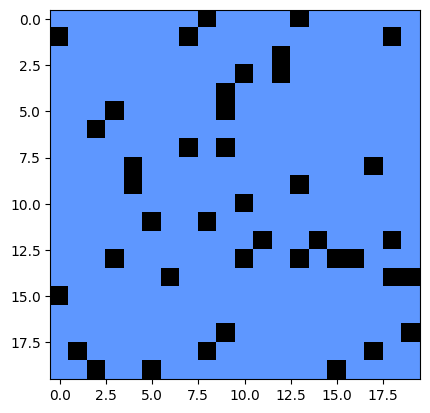

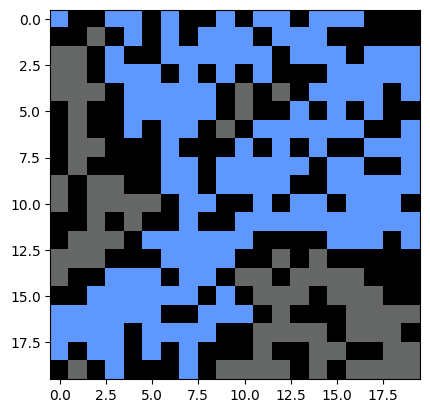

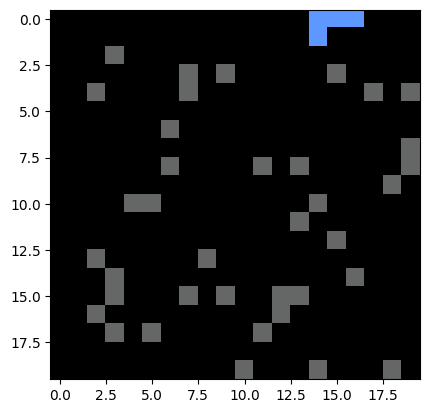

In [13]:
# Import William's solution
#from solutions.percolation import PercolationSimulation

from matplotlib.colors import LinearSegmentedColormap
def plot_percolation(mat):
    """
    Plots a percolation matrix, where 0 indicates a blocked site, 1 indicates an empty 
    site, and 2 indicates a filled site
    """
    cvals  = [0, 1, 2]
    colors = [(0, 0, 0), (0.4, 0.4, 0.4), (0.372549, 0.596078, 1)]

    norm = plt.Normalize(min(cvals), max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)
    plt.imshow(mat, cmap=cmap, vmin=0, vmax=2)


model = PercolationSimulation(n=20, random_state=0, p=0.1)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

model = PercolationSimulation(n=20, random_state=0, p=0.4)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)


model = PercolationSimulation(n=20, random_state=0, p=0.9)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

Running replicate simulations for p = 0.0
Running replicate simulations for p = 0.041666666666666664
Running replicate simulations for p = 0.08333333333333333
Running replicate simulations for p = 0.125
Running replicate simulations for p = 0.16666666666666666
Running replicate simulations for p = 0.20833333333333331
Running replicate simulations for p = 0.25
Running replicate simulations for p = 0.29166666666666663
Running replicate simulations for p = 0.3333333333333333
Running replicate simulations for p = 0.375
Running replicate simulations for p = 0.41666666666666663
Running replicate simulations for p = 0.4583333333333333
Running replicate simulations for p = 0.5
Running replicate simulations for p = 0.5416666666666666
Running replicate simulations for p = 0.5833333333333333
Running replicate simulations for p = 0.625
Running replicate simulations for p = 0.6666666666666666
Running replicate simulations for p = 0.7083333333333333
Running replicate simulations for p = 0.75
Running

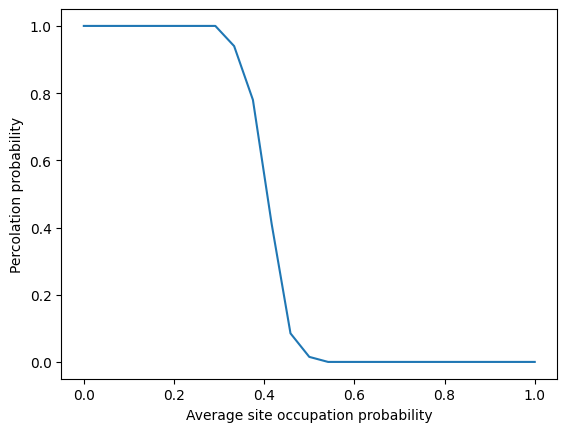

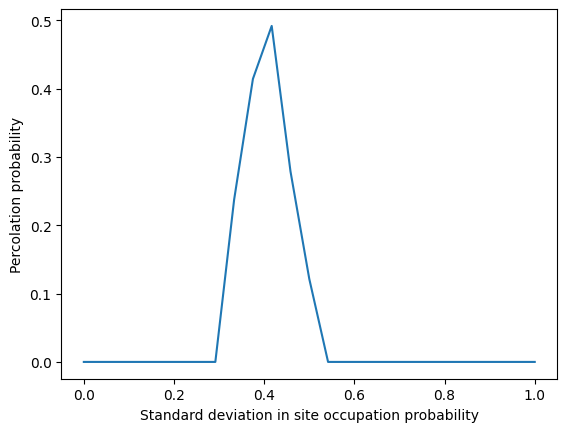

Finished simulation 0
Finished simulation 500
Finished simulation 1000
Finished simulation 1500
Finished simulation 2000
Finished simulation 2500
Finished simulation 3000
Finished simulation 3500
Finished simulation 4000
Finished simulation 4500


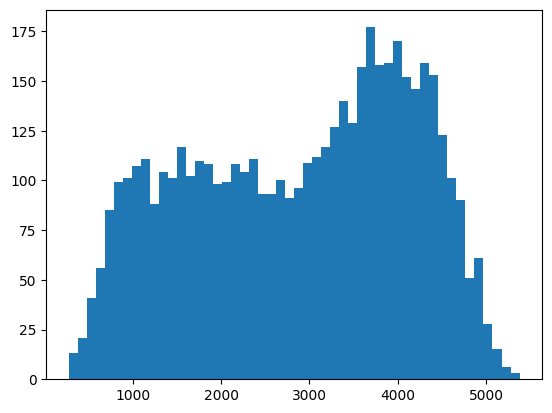

In [14]:
# Import William's solution
#from solutions.percolation import PercolationSimulation

pvals = np.linspace(0, 1, 25) # control parameter for percolation phase transition
n_reps = 200 # number of times to repeat the simulation for each p value

all_percolations = list()
for p in pvals:
    print("Running replicate simulations for p = {}".format(p), flush=True)
    all_replicates = list()
    for i in range(n_reps):
        # Initialize the model
        model = PercolationSimulation(30, p=p)
        all_replicates.append(model.percolate())
    all_percolations.append(all_replicates)

plt.figure()
plt.plot(pvals, np.mean(np.array(all_percolations), axis=1))
plt.xlabel('Average site occupation probability')
plt.ylabel('Percolation probability')

plt.figure()
plt.plot(pvals, np.std(np.array(all_percolations), axis=1))
plt.xlabel('Standard deviation in site occupation probability')
plt.ylabel('Percolation probability')

plt.show()


## Just from curiousity, plot the distribution of cluster sizes at the percolation threshold
## why does it appear to be bimodal?
all_cluster_sizes = list()
p_c = 0.407259
n_reps = 5000
for i in range(n_reps):
    model = PercolationSimulation(100, p=p_c)
    model.percolate()
    cluster_size = np.sum(model.grid_filled == 2)
    all_cluster_sizes.append(cluster_size)

    if i % 500 == 0:
        print("Finished simulation {}".format(i), flush=True)

all_cluster_sizes = np.array(all_cluster_sizes)

plt.figure()
plt.hist(all_cluster_sizes, 50);

In [ ]:
"""
Q3
    The severly drop point occurs near 0.4, this may comes from we needs two adjacent grid both 1 to let the water go through. Therefore, it
    may be harder for the water to pass through than p it self.    


"""

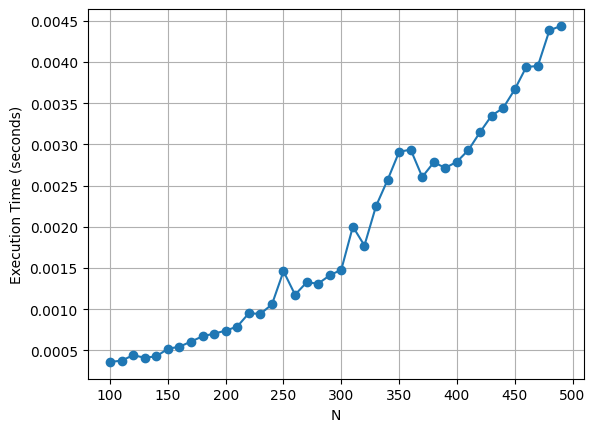

In [23]:
import timeit

x_values = []
execution_times = []

for x in range(100,500,10):
    x_values.append(x)
    execution_time = timeit.timeit(lambda: PercolationSimulation(x, p=p), number=5)
    execution_times.append(execution_time / 5)
    
plt.plot(x_values, execution_times, marker='o', linestyle='-')
plt.xlabel('N')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

In [ ]:
"""
The time complexity should be O(nlogn)
"""